In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv(r"mushroom_reports.csv")
df.head()

,title,substance,age,weight,gender,report_text
0,Forced Fascism for Rejecting the Goddess,Psilocybin,Age at time of experience: 20,155 lb,Male,DOSE:5 mloralMushrooms - P. cubensis(dried)BOD...
1,Loss of Presence,Psilocybin,Age at time of experience: Not Given,145 lb,Male,DOSE:3.5 goralMushrooms - P. cubensis(dried)BO...
2,Memory Exploration,Psilocybin,Age at time of experience: Not Given,115 lb,Male,DOSE:T+ 0:003.5 goralMushrooms - P. cubensis(d...
3,The Gandhi Experiment,Psilocybin,Age at time of experience: Not Given,155 lb,Not Specified,DOSE:1.75 goralMushrooms(dried)BODY WEIGHT:155...
4,Meeting the Eternal Mushroom Tribe,Psilocybin,Age at time of experience: 37,90 kg,Male,DOSE:1.3 goralMushrooms - P. cubensis(dried)BO...


In [2]:
import re
import contractions

def clean_psychedelic_report(text):
    """Initial structure cleanup: remove BODY WEIGHT... and trailing metadata"""
    if pd.isna(text):
        return ""

    text = text.replace('\xa0', ' ').replace('\n', ' ').strip()

    # Remove everything before BODY WEIGHT
    text = re.sub(r"^.*?BODY WEIGHT:\s*\d+\s*\w+\s*", "", text)

    # Remove everything after Exp Year
    end_match = re.search(r"Exp Year: \d{4}ExpID:", text)
    if end_match:
        text = text[:end_match.start()]

    return re.sub(r'\s{2,}', ' ', text).strip()

def remove_duplicates(text):
    """Remove repeated sentences"""
    sentences = text.split('. ')
    seen = set()
    unique_sentences = []
    for s in sentences:
        s_clean = s.strip()
        if s_clean and s_clean not in seen:
            seen.add(s_clean)
            unique_sentences.append(s_clean)
    return '. '.join(unique_sentences)

def final_nlp_clean(text):
    """Final normalization and cleaning for NLP"""
    if pd.isna(text):
        return ""

    # Contractions
    text = contractions.fix(text)

    # Remove parentheticals
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'\[[^\]]*\]', '', text)
    
    # Replace em/en dash, ellipsis, and double hyphen with comma
    text = text.replace('—', ',').replace('–', ',').replace('…', ',').replace('--', ',')

    # Standardize repeated punctuation
    text = re.sub(r'\.{2,}', '.', text)
    text = re.sub(r'!{2,}', '!', text)
    text = re.sub(r'\?{2,}', '?', text)

    # Add spacing after punctuation
    text = re.sub(r'(?<=[.!?])(?=\S)', r' ', text)

    # Separate camelCase
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)

    # Collapse spaces and lowercase
    text = re.sub(r'\s{2,}', ' ', text).lower()

    return text.strip()

In [3]:
df['report_text'] = df['report_text'].apply(clean_psychedelic_report)
df['report_text'] = df['report_text'].apply(remove_duplicates)
df['report_text'] = df['report_text'].apply(final_nlp_clean)

In [4]:
def extract_age(text):
    """Extract age or return 'Not Given'."""
    if pd.isna(text):
        return "Not Given"
    match = re.search(r'Age at time of experience:\s*(\d+|Not Given)', text, re.IGNORECASE)
    return match.group(1) if match else "Not Given"

def extract_weight(text):
    """Extract weight in kg from lb, kg, or stone."""
    if pd.isna(text):
        return np.nan
    match = re.search(r'(\d+)\s*(lb|kg|st)', text.lower())
    if match:
        val, unit = int(match.group(1)), match.group(2)
        if unit == 'kg':
            return val
        elif unit == 'lb':
            return round(val * 0.453592)  # convert lb to kg
        elif unit == 'st':
            return round(val * 6.35029)   # convert stone to kg
    return np.nan

# Apply to columns
df['age'] = df['age'].apply(extract_age)
df['weight'] = df['weight'].apply(extract_weight)

In [5]:
df.tail()

,title,substance,age,weight,gender,report_text
1005,A Fungal Bridge to the Cosmos,Psilocybin,18,52.0,Female,": 3g cubensis set: sleep deprived , slightly a..."
1006,Psilocybin Therapy for Personal Growth,Psilocybin,54,70.0,Male,"’m 54, was diagnosed with bi-polar disorder at..."
1007,Love in the Eyes of the Reaper,Psilocybin,34,91.0,Male,"the time of this experience, i had taken a lon..."
1008,Hearing the Logos,Psilocybin,34,88.0,Male,is christmas day and i am writing this after e...
1009,Solitary Meditative Trip in the Nepali Jungle,Psilocybin,22,61.0,Male,am a 22 year-old undergraduate from north caro...


In [6]:
df['report_text'][5]

"start: approx. 9:30 pmtrip end: 3:00 amtook: p. cubensis b+ strain dosage: 4. 6g method: tea at about 9:30 pm, my spouse and i made,what we call around here,philosopher's tea, not sure what everyone else calls it. we make it like we would make tea, normally, but with mushrooms and honey for added taste. and we eat the softened mushrooms, too. after that was done, i sat back and waited. we watched some television as we wait for it to kick in. i feel suddenly nauseous, but it is mild. i ride it out. it was like feeling slightly dizzy. this is nothing. i have been pregnant and i have had bad food poisoning, so this is nothing compared to that. we decide to turn on netflix, because,in his opinion, cartoons are great to watch. we settle on invader zim. the colors are so bright that i cannot look at them. i look away only to see rainbows made only of blue and red on my walls. they move when i move my head. that is when i realized that they were starting to kick in. i feel like i have to use

In [7]:
def fix_common_mojibake(text):
    if not isinstance(text, str):
        return text

    replacements = {
        'â€™': "'",
        'â€œ': '"',
        'â€': '"',
        'â€“': '-', 
        'â€”': '-', 
        'â€¦': '...', 
        'Ã©': 'é',
        'Ã¨': 'è',
        'Ã¢': 'â',
        'Ãª': 'ê',
        'Ã´': 'ô',
        'Ã': 'à',
        'Â': '',  # sometimes appears before currency symbols
    }

    for wrong, right in replacements.items():
        text = text.replace(wrong, right)

    return text

df['report_text'] = df['report_text'].apply(fix_common_mojibake)

In [8]:
import re

def fix_leading_contractions_lower(text):
    if pd.isna(text):
        return ""

    # Beginning of text
    text = re.sub(r"^['‘’]m\b", "i am", text)
    text = re.sub(r"^['‘’]ve\b", "i have", text)
    text = re.sub(r"^['‘’]d\b", "i would", text)
    text = re.sub(r"^['‘’]ll\b", "i will", text)

    return text

df['report_text'] = df['report_text'].apply(fix_leading_contractions_lower)

In [9]:
df['report_text'][13]

'i am not sure if i was bored or just looking for something introspective to do, but it was a friday night and i watched the bag of dried shrooms sit on my desk, as if they were waiting for me. i ate a few of them, thankfully they were not crushed or anything. i ate probably a gram or two and let it simmer, i like to do that so i can keep my doses low and see how my mind reacts to it, and if everything checks out, i take the plunge and consume a bit more. i was alone in my room, with nothing to do but to experience things phenomenologically, if that even makes sense. nothing changed quite yet, so i decided to eat about 2 more grams and put on some music. i have a song on my playlist, called pum pum shruum styar . it was quite the song, and i notice my hands become really “handsy”. my hands were indeed, hands. i decide that is crazy and decide to get under the covers and really turn up the volume on my headphones. gatorade by yung lean was after a couple of other relaxing hits. gatorade

In [10]:
# Define a word count function
def count_words(text):
    if pd.isna(text):
        return 0
    return len(str(text).split())

# Apply word count to each report
df['word_count'] = df['report_text'].apply(count_words)

In [11]:
# Count reports <500 and >2500 words
less_than_800 = (df['word_count'] < 500).sum()
greater_than_2000 = (df['word_count'] > 2500).sum()

print(f"Reports with fewer than 500 words: {less_than_800}")
print(f"Reports with more than 2500 words: {greater_than_2000}")

Reports with fewer than 500 words: 34
Reports with more than 2500 words: 86


In [12]:
df.head()

,title,substance,age,weight,gender,report_text,word_count
0,Forced Fascism for Rejecting the Goddess,Psilocybin,20,70.0,Male,"the spring of 2022, i was pretty depressed. i ...",2748
1,Loss of Presence,Psilocybin,Not Given,66.0,Male,second adventure into the mystical realm of ps...,2058
2,Memory Exploration,Psilocybin,Not Given,52.0,Male,:i am 17 and considers myself fairly well vers...,1142
3,The Gandhi Experiment,Psilocybin,Not Given,70.0,Not Specified,to give some background on what this is all ab...,3050
4,Meeting the Eternal Mushroom Tribe,Psilocybin,37,90.0,Male,"i am not an extremely experienced tripper, but...",1346


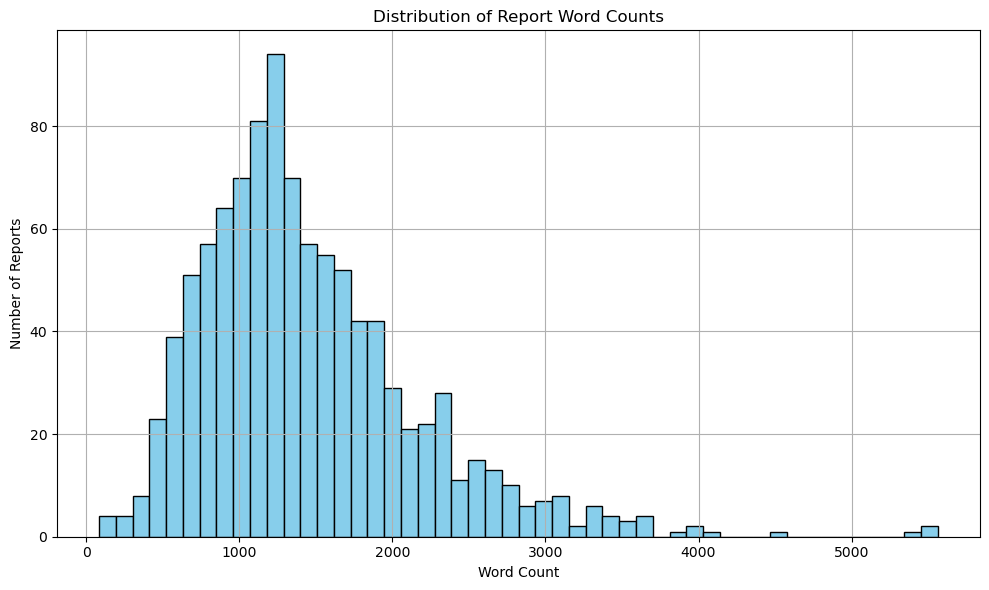

In [13]:
import matplotlib.pyplot as plt

# Plot histogram of word counts
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Report Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Number of Reports')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
df.shape

(1010, 7)

890 within 500 to 2500, we will take 800

In [16]:
# Count reports with fewer than 700 and 800 words
less_than_700 = (df['word_count'] < 700).sum()
less_than_800 = (df['word_count'] < 800).sum()

print(f"Reports with fewer than 700 words: {less_than_700}")
print(f"Reports with fewer than 800 words: {less_than_800}")

Reports with fewer than 700 words: 114
Reports with fewer than 800 words: 159


In [17]:
# Step 1: Filter reports between 500 and 2500 words
filtered_df = df[(df['word_count'] > 500) & (df['word_count'] < 2500)]

# Step 2: Randomly sample 800 reports from the filtered DataFrame
sampled_df = filtered_df.sample(n=800, random_state=42)  # random_state ensures reproducibility

# Step 3: Save to CSV
sampled_df.to_csv("mushroom_800_reports.csv", index=False)

print(f"Filtered {len(filtered_df)} reports, saved 800 to 'final_800_reports.csv'")

Filtered 890 reports, saved 800 to 'final_800_reports.csv'
